In [1]:
import os
import itertools
import random
from math import log, exp, sqrt

from IPython.display import clear_output

import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.colors import LinearSegmentedColormap
from cycler import cycler


import matplotlib.animation as animation

import numpy as np
from scipy import stats
from numpy.linalg import norm

import ars

from BayesW_utils import *
from distributions import *

The time-to-event data is generated following the formula for the log time of individual i:

$$ \log Y_i = \mu + x_i \beta + \frac{w_i}{\alpha} + \frac{K}{\alpha} $$

where $\mu$ is the intercept, $x_i$ are the markers of individual, $\beta$ are the effects, $w_i$ are the random errors, $\alpha$ is the shape parameter of the Weibull distribution (Y) ("variance") and K is the EuMasc constant.

We will fix the following parameters:
- $\mu$=10
- $\alpha$=0.5
- genetic variance $\sigma_G^2$=0.5 

and the rest of the data are drawn from a distribution

-  $w_i \sim Gumbell(0,1)$ (standard extreme value distribution)
- $\beta \sim N(0,1)$
- $x_i \sim N(0, \sigma_G)$

Then $x_i\beta = g_i \sim N(0, \sigma_G)$.

And $\log Y_i$ follows a Gumbell distribution with 

$$E(log(Y_i)|) = \mu + x_i\beta$$

$$ Var(log(Y_i)|\mu +x_i\beta) = \frac{\pi^2}{6\alpha^2} $$

In [66]:
mu_real = 0.5
alpha_real = 2.5
sigma_g_real = 0.5

Text(0, 0.5, 'PDF(x)')

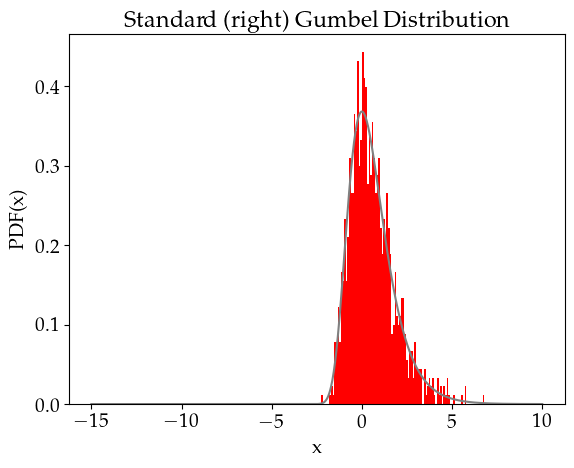

In [3]:
gumbel_dis = stats.gumbel_r(loc=0, scale=1)
# Generate data points
x = np.linspace(-15, 10, num=1000)

# Create Gumbel distribution object
gumbel_data = gumbel_dis.rvs(size=1000)

# Calculate PDF of Gumbel distribution for each data point
pdf = gumbel_dis.pdf(x)

# Plot the PDF of the Gumbel distribution
plt.hist(gumbel_data, density=True, bins=100)
plt.plot(x, pdf)
plt.title('Standard (right) Gumbel Distribution')
plt.xlabel('x')
plt.ylabel('PDF(x)')

In [62]:
n_markers = 2000
n_samples = 1000

In [5]:
w = gumbel_dis.rvs(size=(n_samples,1))
betas = np.random.normal(0, np.sqrt(sigma_g_real/n_markers), size = (n_markers, 1)) #simulate causal betas
markers = np.random.normal(0, 1, (n_samples, n_markers))

In [26]:
g = markers.dot(betas)
np.mean(g), np.var(g)

(0.005166795959029912, 0.49848251765127677)

''

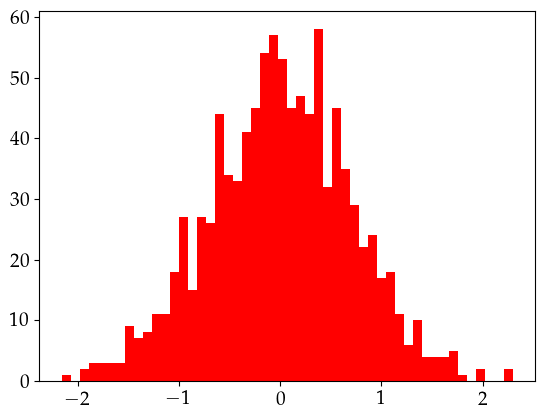

In [27]:
plt.hist(g, bins=50)
;

In [67]:
log_data = mu_real + g + w/alpha_real + np.euler_gamma/alpha_real

In [68]:
np.mean(np.exp(log_data)), np.var(np.exp(log_data))

(4.005287392776522, 36.198355040117264)

''

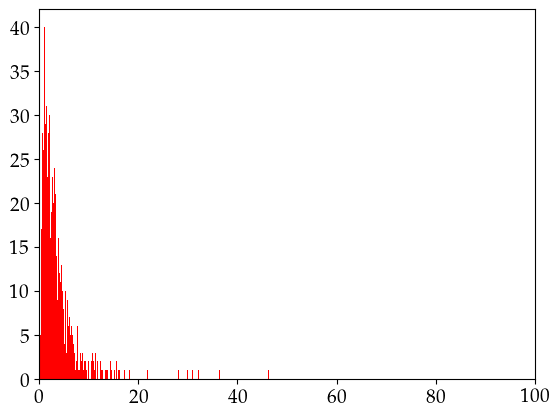

In [72]:
plt.hist(np.exp(log_data), bins=1000)
plt.xlim(0,100)
;

''

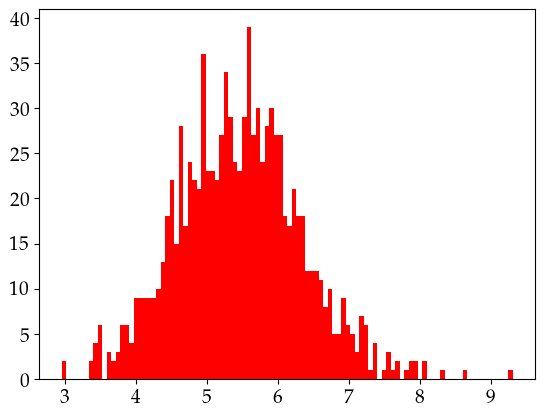

In [53]:
plt.hist(log_data, bins=100)
;

In [47]:
np.var(log_data)

0.7690508113821604

In [73]:
print("Mean of first sample: ", np.mean(log_data[0]))
print("Expected value: ", mu_real + g[0][0])

Mean of first sample:  -0.12715630429406052
Expected value:  -0.8186262594560738


In [74]:
print("Sample variance: ",np.var(log_data))
print("Phenotypic variance: ",sigma_g_real + np.pi**2/(6*alpha_real**2))

Sample variance:  0.7690508113821604
Phenotypic variance:  0.7631894506957162


In [57]:
pars = {"alpha": alpha_real,
        "sigma_g": sigma_g_real,
        "d": 10, 

        "var_mu": 100, 
        "var_delta": 100,
        
        "alpha_zero": 0.01,
        "kappa_zero": 0.01,

        "d_array": np.ones(n_samples),

        "alpha_sigma": 1,
        "beta_sigma": 0.0001
}

In [58]:
f_mu = log_mu(pars, epsilon)
df_mu = dev_log_mu(pars, log_data)

In [41]:
mu_real

5

In [59]:
epsilon = log_data - g

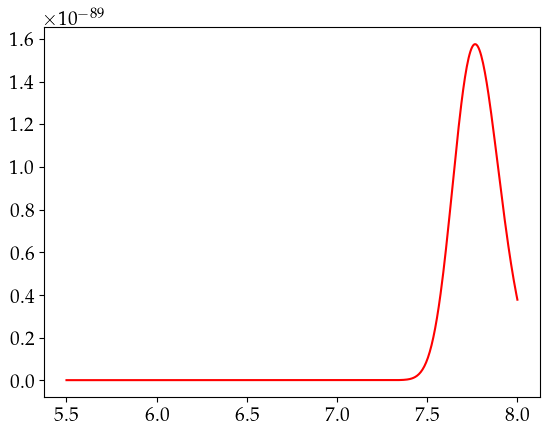

In [61]:
xplot = np.linspace(5.5,8,500)
p = [f_mu(x) for x in xplot]
plt.plot(xplot, np.exp(p))

In [ ]:
def log_mu(pars, epsilon_arr):
    '''computes the log-likelihood of the mu parameter'''
    return lambda x : (-pars['alpha']*x*pars['d'] - \
                       np.sum(np.exp((epsilon_arr - x)*pars['alpha'] -np.euler_gamma)) \
                        - (x**2)/(2*pars["var_mu"]))

In [49]:
-pars['alpha']*5*pars['d']

-12500.0

In [51]:
-np.sum(np.exp((log_data - 9)*pars['alpha'] -np.euler_gamma))

-2.3887462956856123

In [367]:
log_data.mean()

5.053878284589332

How can I define the probabilities of beta and x so that g follows a normal with variance sigma_G? We have to take into account that we are not simple multiplying two variables but also summing over the elements, so this changes everything...